In [6]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.nn import convolution

from celluloid import Camera
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output
from time import time

In [51]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [52]:
from FiniteDifference.Maxwell2d import Maxwell2DFiniteDifference

ModuleNotFoundError: No module named 'FiniteDifference'

In [46]:
mwell = Maxwell2DFiniteDifference(mesh_size=0.01, step_size=1e-3, )

In [49]:
B, E, I, p = mwell.evolve(lambda x: np.exp(-np.sum(np.square((x-np.array([0.5,0.5]).reshape((2,1,1)))/0.1), axis=0)), lambda x: np.zeros(mwell._U.shape), lambda x: np.zeros(mwell._p.shape), 1)

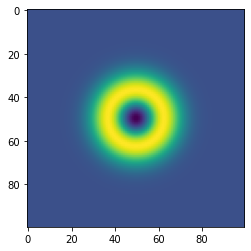

In [50]:
plt.imshow(B)

In [26]:
N = 1000
dt = 0.001
h = 0.5
resis = 10000

In [27]:
_U = np.zeros(shape=(N, N, 2))
_I = np.zeros(shape=(N, N, 2))
_B = np.zeros(shape=(N, N, 1))
_p = np.zeros(shape=(N, N, 1))

_R = resis * np.ones(shape=(N, N, 1))
_eps = np.ones(shape=(N, N, 1))
_mu = np.ones(shape=(N, N, 1))

In [28]:
X = np.array([[0, 0, 0], [1, -1, 0],[0, 0, 0]])
Y = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
_continuity_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3)

In [29]:
X = np.array([[0, 0, 0], [0, 1, 0],[0, -1, 0]])
Y = np.array([[0, 0, 0], [0, -1, 1],[0, 0, 0]])
_faraday_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3) / h ** 2

In [30]:
X = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
Y = np.array([[0, 0, 0], [-1, 1, 0],[0, 0, 0]])
_ampere_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,3,0) * h

In [31]:
Y

array([[ 0,  0,  0],
       [-1,  1,  0],
       [ 0,  0,  0]])

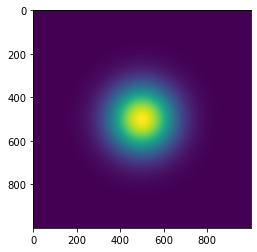

In [32]:
x = np.linspace(0, 10, N)
mesh = np.stack(np.meshgrid(x, x))

_B = np.exp(-np.sum(np.square((mesh-np.array([5,5]).reshape((2,1,1)))/1.5), axis=0))

plt.imshow(_B)

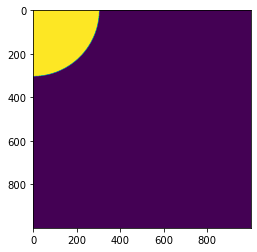

In [33]:
x = np.linspace(0, 10, N)
mesh = np.stack(np.meshgrid(x, x))
U = np.exp(-np.sum(np.square(mesh), axis=0))
plt.imshow(U>0.0001)
_R[U>0.0001]=0.1

In [34]:
_continuity_filter[:,:,0,0]

array([[ 0,  0,  0],
       [ 1, -1,  0],
       [ 0,  0,  0]])

In [35]:
_continuity_filter[:,:,1,0]

array([[ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  0]])

In [36]:
faraday_filter = tf.constant(_faraday_filter, name='faraday_filter', dtype=tf.float64)
ampere_filter = tf.constant(_ampere_filter, name='ampere_filter', dtype=tf.float64)
continuity_filter = tf.constant(_continuity_filter, name='continuity_filter', dtype=tf.float64)

eps = tf.constant(_eps.reshape((1, N, N, 1)), name='dielectricity', dtype=tf.float64)
mu = tf.constant(_mu.reshape((1, N, N, 1)), name='permitivity', dtype=tf.float64)
R = tf.constant(_R.reshape((1, N, N, 1)), name='resistance', dtype=tf.float64)
U = tf.Variable(_U.reshape((1, N, N, 2)), name='e_field', dtype=tf.float64)
I = tf.Variable(_I.reshape((1, N, N, 2)), name='current', dtype=tf.float64)
B = tf.Variable(_B.reshape((1, N, N, 1)), name='b_field', dtype=tf.float64)
p = tf.Variable(_p.reshape((1, N, N, 1)), name='charge_density', dtype=tf.float64)

In [37]:
class cam():
    
    def __init__(self, ):
        self.fig, self.axs = plt.subplots(2, 2)
        self.camera = Camera(self.fig)
        
    def plot(self, rp, i, v, b):
        self.axs[0, 0].imshow(rp)
        self.axs[0, 0].set_title('resistance/charge density')
        self.axs[0, 1].quiver(np.linspace(0,10,20), np.linspace(0,10,20), i[::50,::50,0], i[::50,::50,1], scale=1)
        self.axs[0, 1].set_title('current')
        self.axs[1, 0].imshow(b, vmin=-1, vmax=1)
        self.axs[1, 0].set_title('magnetic field')
        self.axs[1, 1].quiver(np.linspace(0,10,20), np.linspace(0,10,20), v[::50,::50,0], v[::50,::50,1], scale=3)
        self.axs[1, 1].set_title('electric field')
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        for ax in cc.fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])
        self.camera.snap()
        

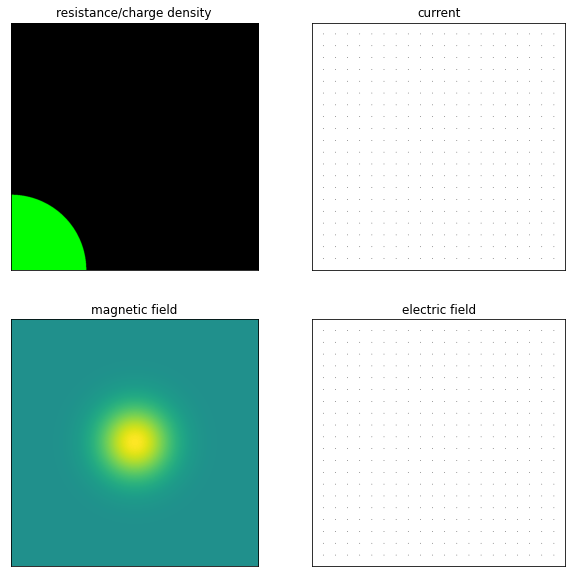

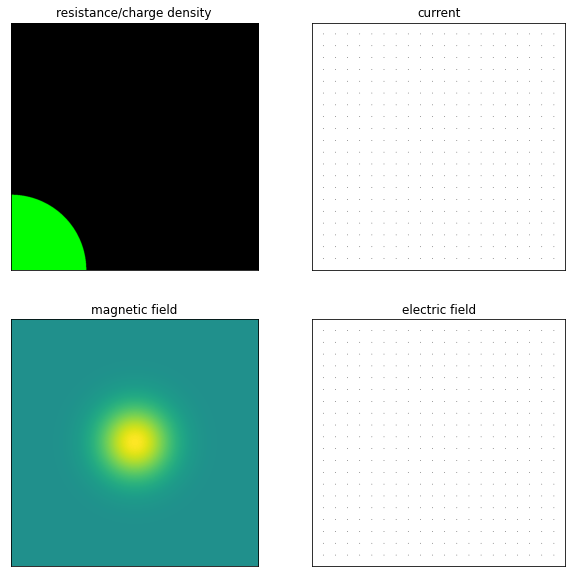

In [38]:
r = np.squeeze(R.numpy())
_p = np.squeeze(p.numpy())
plus = np.vectorize(lambda x: max(x, 0))(_p)
minus = -np.vectorize(lambda x: min(x, 0))(_p)
rp = np.stack([plus, 1 - r / resis, minus]).transpose(2,1,0)
rp = (255*rp).astype(np.uint8)
j = tf.squeeze(I).numpy()
cc = cam()
cc.plot(np.flipud(rp), j / h, tf.squeeze(U).numpy() / h, np.flipud(tf.squeeze(B).numpy()))
cc.fig

In [ ]:
%%capture
cc = cam()
for jter in range(80000):
    I = U / R
    dB = convolution(U, filters=faraday_filter, padding='SAME')
    dp = convolution(I, filters=continuity_filter, padding='SAME')
    dU = (convolution(B, filters=ampere_filter, padding='SAME') / eps / mu - I / eps)

    U.assign_add(dU * dt)
    B.assign_add(dB * dt)
    p.assign_add(dp * dt)
    if jter % 2000 ==0:
        r = np.squeeze(R.numpy())
        _p = np.squeeze(p.numpy())
        plus = _p.copy()
        plus[plus<0] = 0
        minus = -_p
        minus[minus<0] = 0
        rp = np.stack([plus, 1 - r / resis, minus]).transpose(2,1,0)
        rp = (255*rp).astype(np.uint8)
        j = tf.squeeze(I).numpy()
        cc.plot(np.flipud(rp), j / h, tf.squeeze(U).numpy() / h, np.flipud(tf.squeeze(B).numpy()))
anim = cc.camera.animate(blit=True)
clear_output()

In [ ]:
HTML(anim.to_html5_video())